In [1]:
from math import cos, sin, pi

import numpy as np
from numpy import inf
import matplotlib.pyplot as plt

In [2]:
class Map:
    
    def __init__(self, map_path=None):
        self.edges = []

        # Read map from text file
        if map_path:
            with open(map_path) as f:
                for line in f:
                    if line[0] == '#':
                        continue
                    self.add_edge(*[float(c) for c in line.split()])
                    
    def add_obstacle(obstacle):
        pass
    
    def add_edge(self, x1, y1, x2, y2):
        self.edges.append((x1, y1, x2, y2))
        
    def scan_one(self, x, y, theta):
        """returns distances for one angle
        x, y: float
             position in meters
        theta: float
            robot rotation in radians
        alpha: float
            in what direction, relative to robot, to scan
        """
        n = len(self.edges)
        distances = np.zeros((n, 360))
        dxs = np.zeros((n, 360))
        dys = np.zeros((n, 360))
        dthetas = np.zeros((n, 360))
        for i, edge in enumerate(self.edges):
            dist, dx, dy, dtheta = self._intersections(x, y, theta, *edge)
            dxs[i, :] = dx
            dys[i, :] = dy
            dthetas[i, :] = dtheta
            distances[i, :] = dist
        
        min_inds = distances.argmin(axis=0)
        return (
            distances[min_inds, range(360)],
            dxs[min_inds, range(360)],
            dys[min_inds, range(360)],
            dthetas[min_inds, range(360)]
        )
    
    def scan(self, x, y, theta):
        """returns distances and derivatives in 360 degrees
        x, y: float
             position in meters
        theta: float
            robot rotation in radians
        """
        n = len(self.edges)
        distances = np.zeros((n, 360))
        dxs = np.zeros((n, 360))
        dys = np.zeros((n, 360))
        dthetas = np.zeros((n, 360))
        for i, edge in enumerate(self.edges):
            dist, dx, dy, dtheta = self._intersections(x, y, theta, *edge)
            dxs[i, :] = dx
            dys[i, :] = dy
            dthetas[i, :] = dtheta
            distances[i, :] = dist
        
        min_inds = distances.argmin(axis=0)
        return (
            distances[min_inds, range(360)],
            dxs[min_inds, range(360)],
            dys[min_inds, range(360)],
            dthetas[min_inds, range(360)]
        )
    
    def _distance(self, x1, x2, theta, alpha, a1, a2, b1, b2):
        """
        Returns distance given one position, one edge, and an angle alpha
        """
        distances = np.array([inf] * 360)
        dx1 = np.array([inf] * 360)
        dx2 = np.array([inf] * 360)
        dtheta = np.array([inf] * 360)
        a = np.array([[a1, a2]]).T
        b = np.array([[b1, b2]]).T
        x = np.array([[x1, x2]]).T
        for angle in range(360):
            alpha = pi * angle / 180
            try:
                k = 1.0 / ((a2 - b2) * cos(theta + alpha) + sin(theta + alpha) * (b1 - a1))
                A = np.array([
                    [ a2 - b2   , b1 - a1   ],
                    [-sin(theta + alpha), cos(theta + alpha)]
                ])
                s, t = (k * np.dot(A, (a - x))).flatten()
                if 0 <= t <= 1 and 0 < s:
                    distances[angle] = s
                    dx1[angle] = k * (b2 - a2)
                    dx2[angle] = k * (a1 - b1)
                    f = (a1 - x1) * (a2 - b2) + (a2 - x2) * (b1 - a1)
                    fprim = np.array([cos(theta + alpha), sin(theta + alpha)]).dot(x - a)
                    g = 1 / k
                    gprim = np.array([cos(theta + alpha), sin(theta + alpha)]).dot(b - a)
                    dtheta[angle] = k ** 2 * (-gprim * f)
            except ZeroDivisionError:
                pass
        
        return distances, dx1, dx2, dtheta

    def _intersections(self, x1, x2, theta, a1, a2, b1, b2):
        """
        Returns distances and derivatives given one position and one edge
        """
        distances = np.array([inf] * 360)
        dx1 = np.array([inf] * 360)
        dx2 = np.array([inf] * 360)
        dtheta = np.array([inf] * 360)
        a = np.array([[a1, a2]]).T
        b = np.array([[b1, b2]]).T
        x = np.array([[x1, x2]]).T
        for angle in range(360):
            alpha = pi * angle / 180
            try:
                k = 1.0 / ((a2 - b2) * cos(theta + alpha) + sin(theta + alpha) * (b1 - a1))
                A = np.array([
                    [ a2 - b2   , b1 - a1   ],
                    [-sin(theta + alpha), cos(theta + alpha)]
                ])
                s, t = (k * np.dot(A, (a - x))).flatten()
                if 0 <= t <= 1 and 0 < s:
                    distances[angle] = s
                    dx1[angle] = k * (b2 - a2)
                    dx2[angle] = k * (a1 - b1)
                    f = (a1 - x1) * (a2 - b2) + (a2 - x2) * (b1 - a1)
                    fprim = np.array([cos(theta + alpha), sin(theta + alpha)]).dot(x - a)
                    g = 1 / k
                    gprim = np.array([cos(theta + alpha), sin(theta + alpha)]).dot(b - a)
                    dtheta[angle] = k ** 2 * (-gprim * f)
            except ZeroDivisionError:
                pass
        
        return distances, dx1, dx2, dtheta
m = Map(map_path='map.txt')

# Test
$x = 2$

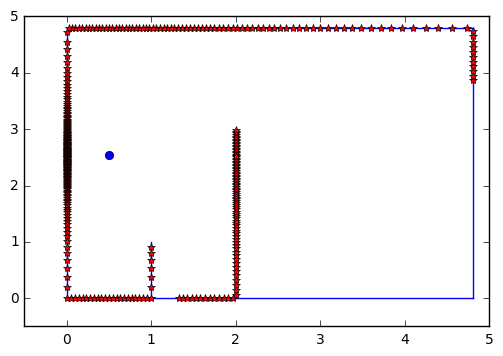

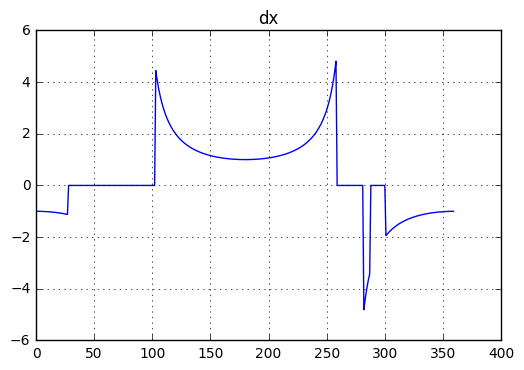

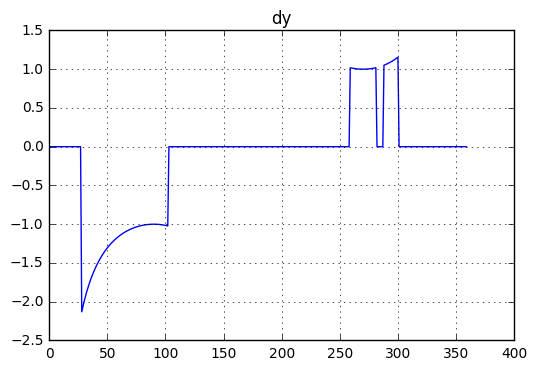

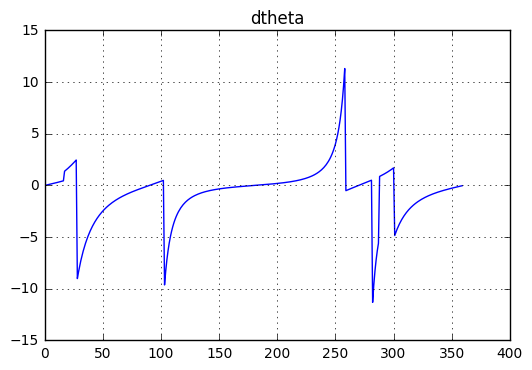

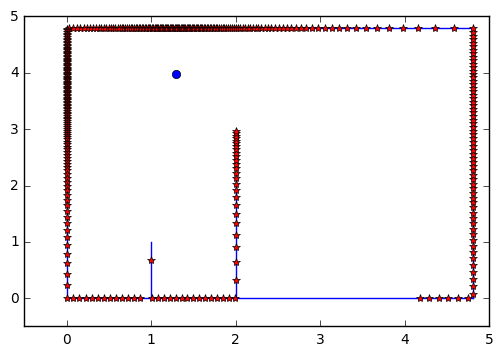

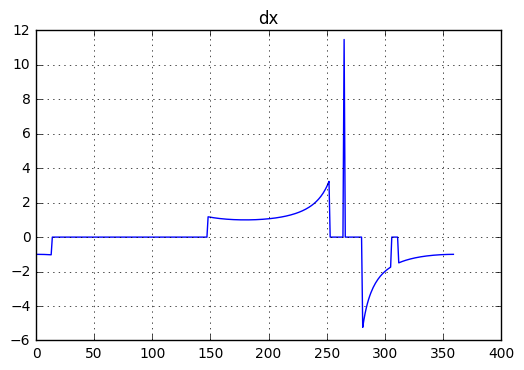

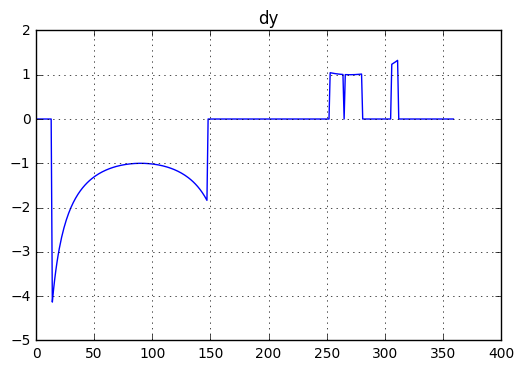

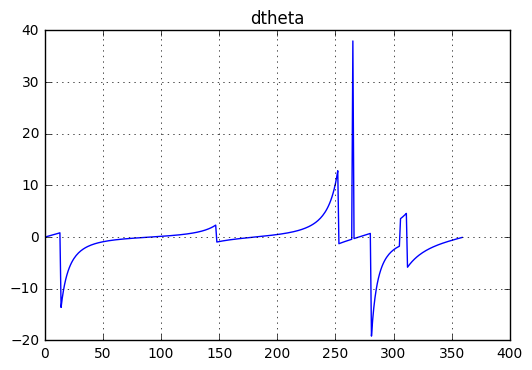

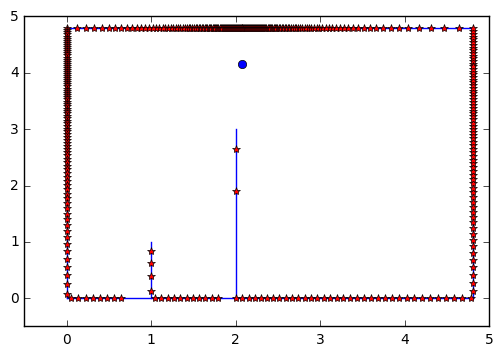

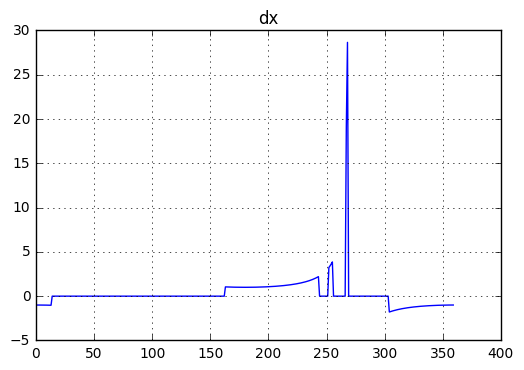

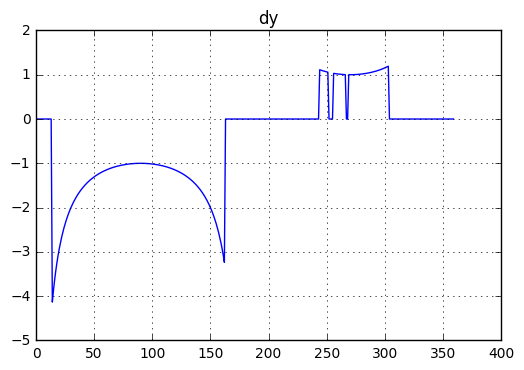

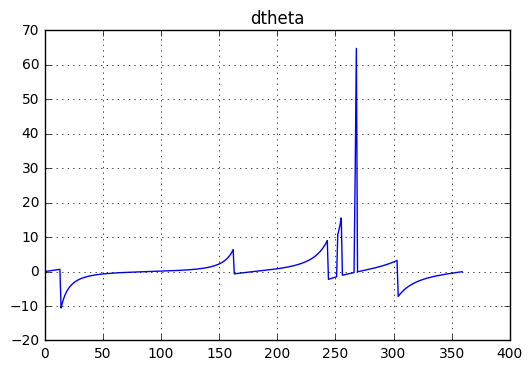

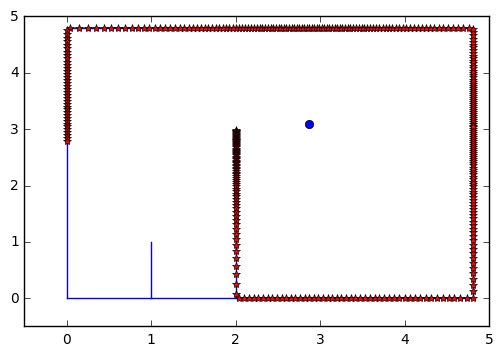

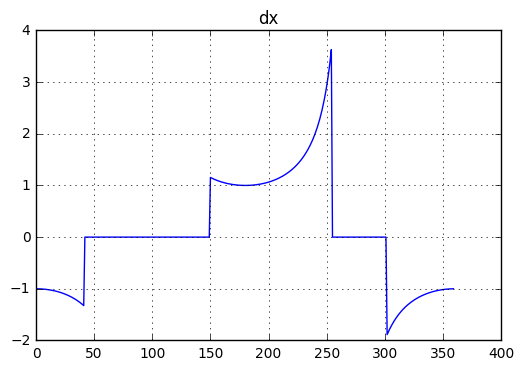

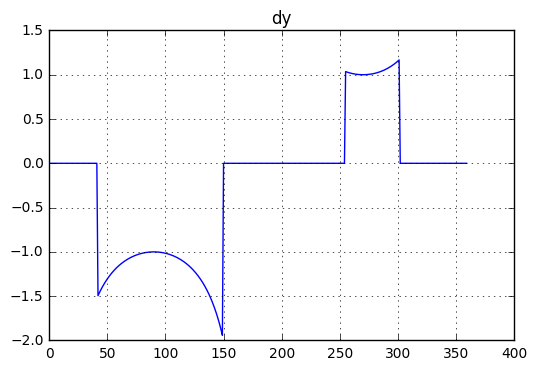

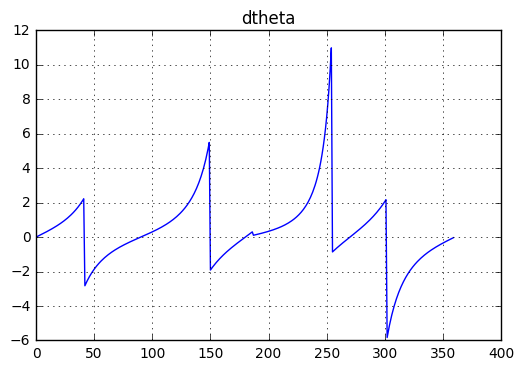

In [5]:
xs = np.linspace(0.5, 3.5, 20)
ys = 1 + 3.6 * xs - xs ** 2

theta = 0.0
for id, (x, y) in enumerate(zip(xs[::5], ys[::5])):
    for a, b, c, d in m.edges:
        plt.plot([a, c], [b, d], 'b')
    plt.xlim(-0.5, 5.0)
    plt.ylim(-0.5, 5.0)
    plt.plot(x, y, 'bo')
    dists, dx, dy, dtheta = m.scan(x, y, theta)
    for i, d in enumerate(dists):
        plt.plot(x + d * cos(pi * i / 180), y + d * sin(pi * i / 180), 'r*')
    plt.show()
    dists, dx, dy, dtheta = m.scan(x, y, theta)
    plt.title('dx')
    plt.plot(dx)
    plt.grid(True)
    plt.show()
    plt.title('dy')
    plt.plot(dy)
    plt.grid(True)
    plt.show()
    plt.title('dtheta')
    plt.plot(dtheta)
    plt.grid(True)
    plt.show()